## *<font color = maroon> Notebook 2: </font>* Detection of Sea Surface Temperature (SST) Filaments and Fronts - 
**This script includes the following:** <br> 
1. **Automated Detection**<br>
    - **Filaments** - *A parabolic dip in SST, where SST transitions sharply like a front, but with two sides and cool water in the middle*
        - Continous track - no gaps in data larger than 50 meters - has local minima in SST 
        - A SST gradient exceeding user set <font color = magenta> threshold </font>
        - Boat heading does not change more than 90$^{\circ}$ in structure
        - Symmetry in structure, i.e. change in SST on cooler side of asymmetrical filament shape is at least 30% of SST change for warmer side.
    - **Fronts** - *A sharp, step-like change in SST*
        - **If at least one of the filament defintions is not met, except for <font color = magenta> gradient threshold </font>, a filament is detected allowing for mutually exclusive recording of structures** 

2. **Data Ensemble** <br>
    - Individual structures, fronts and filaments, are stored in respective dictionaries for either all cruises or a <font color = magenta> user specified date </font>
    - Filaments
        - Normalized origin for all structures at the local SST minima
        - Limits of structure extend to bordering local maximas - hence parabolic shape
    - Fronts 
        - Normalized origin at peak SST gradient
        - Limits of fronts adjustable <font color = magenta> by length  </font> or default to neighboring minima and maxima.
    **For ensembles of all data, users may <font color = magenta> normalize shape </font> by keeping 'cool' sides (side of lesser change) to left for fronts (asymmetrical filaments)** <p>

3. **Saving Data - RECOMMENDED** <br>
    - It is recommended that ensembles of fronts and filaments of all cruises are <font color = magenta> saved in .pkl files </font> - `front_ensemble` & `fil_ensemble`, respectively - for use in future scripts. **This is necessary for plotting probabilities of structures across bay.**
    
<font color = maroon> **Code is organized based on the three sections defined above, with <font color = magenta> parameter </font> definitions below** </font>

In [1]:
# --------- Edit Code --------- #

# Detection Parameters
window_size = 25      # Multiply by 10 for physical distance (m) of smoothing relative to track
gradient_thresh = 1.0 # in deg. C per KM

# Treating Data - true means removal (rmv)
rmv_nan = False
rmv_mdr = True

# General Graphing Fontsizes
fs_tick  = 35
fs_label = 30 
fs_title = 40

# Individual Cruise or ALL Cruise Ensembles 
cruisedate = []    # Leave empty if no cruise 

# Normalize Cruise Data - set to false in code for indiviudal plots
normalize_ensembles = True

# Saving options
saveplots      = False
save_ensembles = False

#### Library Import

In [2]:
# ----- Import Libraries ----- #

# Functions
import numpy as np
import functions as zf

# Files
import pickle

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib import colors
import matplotlib as mlb
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, LogNorm, NoNorm
import matplotlib.patches as mpatches
import matplotlib.axes as AX
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from matplotlib.axes import inset_axes

# Mapping
import cartopy
import cartopy.crs as ccrs #importing the cartopy coordinate reference system library
import cartopy.feature as cfeature #importing the cartopy library of surface features
import cartopy.io.shapereader as shpreader

# Smoothing
import scipy.io as sio
import scipy.stats as ss
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import peak_prominences

# ----- IMPORT Track dictionary as pkl ----- #
# Read dictionary pkl file
with open('track_data.pkl', 'rb') as ztd:
    zodiac_track_data = pickle.load(ztd)

In [3]:
def is_subset(arr1, arr2):

    # Iterate over each element in the second array
    for i in range(len(arr2)):
        found = False

        # Check if the element exists in the first array
        for j in range(len(arr1)):
            if arr2[i] == arr1[j]:
                found = True
                break

        # If any element is not found, return false
        if not found:
            return False

    # If all elements are found, return true
    return True

### 1. Automated Detection 

#### Filaments 

In [4]:
# Arrays to fill #
failed_dates   = [] # List of dates Zodiac did not leave
zero_grad      = [] # indices of where a sst local max and min resides 

# Arrays for Data Analysis # 
filament_width = []
symmetry       = []

# Ensemble of ALL filaments #
filament_ensemble = {}

# This master loop goes through each possible date the zodiac went out and grabs corresponding data 
num = 0 # For counting structures
for index, date in enumerate(zodiac_track_data):
        
    # If we only want one cruise, we reset ensemble each iteration until proper date is found and loop is exited
    # As we cycle through dates, we skip the rest of the loop until individual date is found
    if len(cruisedate) != 0:
        if cruisedate[0] == date:
            filament_ensemble = {}
            normalize_ensembles = False # Overwrites for individual plots 
        else:
            continue 

    # Reset subset array to ensure there are no copies of the same structure
    # NOTE: This means the same excat structure due to errors in surface sampler data, the same structure but at different
    # positions may be marked multiple times - no other way to know...
    subset_lat, subset_lon = [],[]

    try:
        lat, lon, SST, flu = zf.select_track(date, zodiac_track_data, excludenans=rmv_nan, excludemdr=rmv_mdr)
        # Data Processing, Filtering, & Gradients for SST #
        dist_processed, sst_processed = zf.data_processing(lat, lon, SST, 10)
        grad_dist_sst, grad_sst, lat_sst, lon_sst, sst_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, sst_processed, dist_processed)
        # Data Processing, Filtering, & Gradients for Flu #
        dist_processed, flu_processed = zf.data_processing(lat, lon, flu, 10)
        grad_dist_flu, grad_flu, grad_lat_flu, grad_lon_flu, flu_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, flu_processed, dist_processed)

        # Get final details on cruise path - Bearing (Direction of boat)
        bearing = np.around(zf.bearing(lat_sst, lon_sst), 2)
        # split this into components (vector form)
        lon_comp = 1*np.sin(np.around(bearing, 0)*(np.pi/180))
        lat_comp = 1*np.cos(np.around(bearing, 0)*(np.pi/180))

        # Find the local SST minimum and maximums #
        sst_loc_max, _ = find_peaks(sst_filtered, height=0) # READ ABOUT FIND PEAKS ####
        sst_loc_min, _ = find_peaks(-1*sst_filtered, height = -30)
        zero_grad = np.concatenate((sst_loc_max, sst_loc_min))
        # Brefily ensure they are ordered, as the minumums and maximum indices are appended out of order (not along track...)
        for i in range(0, len(zero_grad)):
            for j in range(i+1, len(zero_grad)):
                if(zero_grad[i] > zero_grad[j]):
                    temp = zero_grad[i];
                    zero_grad[i] = zero_grad[j];
                    zero_grad[j] = temp;

        # With our organized array of local maximum and minimum indices, we begin selecting individual segments
        start = 0 # Begin at 0th index
        for i in range(len(zero_grad)-2):    

            end = start+1                                     # Index to next one over 
            index1, index2 = zero_grad[start], zero_grad[end] # index 1 and 2 are now the indices that define 1/2 a segment 
            start = end                                       # Move start over 1 to grab next segment in loop

            # Ensure that we start with a dip
            if sst_filtered[index1] > sst_filtered[index2]:
                # If true, we become concerned in other portion, hence index 3, which is the peak following our central minima
                index3 = zero_grad[end+1]
                # Make sure that somewhere in our filament there is a sufficiently large gradient 
                if (np.max(grad_sst[index1:index3]) >= gradient_thresh):

                    # If true, check that we maintain a relatively straight bearing 
                    filament_xcomps, filament_ycomps = lon_comp[index1:index3], lat_comp[index1:index3]
                    X, Y = lon_comp[index1], lat_comp[index1]
                    angles = []
                    for i in range(len(filament_xcomps)-1):
                        try:
                            xi, yi = filament_xcomps[i+1], filament_ycomps[i+1]
                            angles = np.append(angles, (np.arccos(np.dot([X, Y], [xi, yi])/(np.sqrt(X**2 + Y**2)*np.sqrt(xi**2 + yi**2))))*(180/np.pi))
                        except:
                            angles = np.append(angles, np.mean(angles))
                        continue
                    # Ensuring that heading does not change more than 90 deg
                    if np.max(angles) < 90:    
                        # Save Filament Data # 
                        filament_distance = dist_filtered[index1:index3]
                        filament_sst      = sst_filtered[index1:index3]
                        filament_flu      = flu_filtered[index1:index3]
                        filament_lat      = lat_sst[index1:index3]
                        filament_lon      = lon_sst[index1:index3]

                        # order from 'small' to 'large' change in SST 
                        if normalize_ensembles == True:
                            if filament_sst[-1] < filament_sst[0]:
                                filament_sst = filament_sst[::-1]
                                filament_flu = filament_flu[::-1]
                            # This impacts how we measure symmetry 
                            symm_test = (filament_sst[0]-np.min(filament_sst))/(filament_sst[-1]-np.min(filament_sst))
                        else: 
                            # If we do not normalize, we still must ensure that symmetry test is done properly for 
                            # either case of asymmetry
                            if filament_sst[-1] < filament_sst[0]:
                                symm_test = (filament_sst[-1]-np.min(filament_sst))/(filament_sst[0]-np.min(filament_sst))
                            else:
                                symm_test = (filament_sst[0]-np.min(filament_sst))/(filament_sst[-1]-np.min(filament_sst))

                        # FINAL CHECKS - SYMMETRY AND DISCONTINUITIES
                        if (symm_test) >= .30:
                            if len(np.diff(filament_distance)[np.diff(filament_distance) > 0.05]) == 0:

                                # Normalize distances  
                                index          = np.where(filament_sst == np.min(filament_sst))
                                min_index      = index[0]
                                equal_dist     = filament_distance - filament_distance[min_index-1] # Equidistant View of Front from minima
                                filament_width = np.append(filament_width, abs(equal_dist[0])+abs(equal_dist[-1])) # Single value for size of front

                                # SST 
                                equal_sst = filament_sst - filament_sst[min_index]
                                fil_symm  = (filament_sst[0]-np.min(filament_sst))/(filament_sst[-1]-np.min(filament_sst))
                                symmetry  = np.append(symmetry, fil_symm)

                                # Positions of Filament (minima)
                                min_lat = filament_lat[min_index]
                                min_lon = filament_lon[min_index]
                                # Orientation of Filament
                                x_comp  = np.mean(filament_ycomps)
                                y_comp  = np.mean(-1*filament_xcomps)

                                # Ensure no repeat
                                if not is_subset(subset_lat, np.round(min_lat,4)) and not is_subset(subset_lon, np.round(min_lon,4)):
                                    # Set subset for this date to ensure same track is not checked twice
                                    subset_lat = np.append(subset_lat, np.round(min_lat, 4))
                                    subset_lon = np.append(subset_lon, np.round(min_lon,4))

                                    # Counter
                                    date_count = 1
                                    fil_number = num+1 # adjusts for pythons zero-based indexing
                                    num        = fil_number
                                    print(f'Filament {fil_number} Detected on {date}', end = '\r')

                                    # Save details on filament in dictionary style
                                    cruises = {'Date': (date), \
                                               # Filament Imaging
                                               'Equi-Dist': (equal_dist), 'Equi-SST': (equal_sst), \
                                               # General Data
                                               'Distance': (filament_distance), 'SST': (filament_sst), 'Flu': (filament_flu), \
                                               'Latitude': (filament_lat), 'Longitude': (filament_lon), \
                                               'Min-Lat': (min_lat), 'Min-Lon': (min_lon), \
                                               'x-comp': (x_comp), 'y-comp': (y_comp), \
                                               'Symmetry': (fil_symm)}

                                    # Save to dictionary with corresponding number
                                    filament_ensemble[fil_number] = cruises

    except:
            # Dates may fail based on above logicals of nans - cruises where TSG or fluorometer did not record
            # and exclusion of MDR - cruises that did not leave marina
            failed_dates = np.append(failed_dates, date)
    continue 
                        

C:\Users\gmanh\AppData\Local\Temp\ipykernel_21084\2588712301.py:81: RuntimeWarning: invalid value encountered in arccos
  angles = np.append(angles, (np.arccos(np.dot([X, Y], [xi, yi])/(np.sqrt(X**2 + Y**2)*np.sqrt(xi**2 + yi**2))))*(180/np.pi))


#### Fronts

In [5]:
# Arrays to fill 
failed_dates = [] # List of dates Zodiac did not leave
zero_grad    = [] # indices of where a sst local max and min resides 

# Arrays for Data Analysis 
front_width = []
sst_change  = []

# Ensemble of ALL Fronts
front_ensemble = {}

# This master loop is simply to go through each possible date the zodiac went out, and grab corresponding data 
num = 0 # For counting fronts in our ensemble
for index, date in enumerate(zodiac_track_data):
        
    # If we only want one cruise, we reset ensemble each iteration until proper date is found and loop is exited
    # As we cycle through dates, we skip the rest of the loop until individual date is found
    if len(cruisedate) != 0:
        if cruisedate[0] == date:
            front_ensemble = {}
            normalize_ensembles = False # Overwrites for individual plots 
        else:
            continue 
            
    # Reset subset array to ensure there are no copies of the same structure
    # NOTE: This means the same excat structure due to errors in surface sampler data, the same structure but at different
    # positions may be marked multiple times - no other way to know...
    subset_lat, subset_lon = [],[]
        
    try: 
        lat, lon, SST, flu = zf.select_track(date, zodiac_track_data, excludenans=rmv_nan, excludemdr=rmv_mdr)

        # Data Processing, Filtering, & Gradients for SST
        dist_processed, sst_processed = zf.data_processing(lat, lon, SST, 10)
        grad_dist_sst, grad_sst, lat_sst, lon_sst, sst_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, sst_processed, dist_processed)
        # Data Processing, Filtering, & Gradients for Flu
        dist_processed, flu_processed = zf.data_processing(lat, lon, flu, 10)
        grad_dist_flu, grad_flu, grad_lat_flu, grad_lon_flu, flu_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, flu_processed, dist_processed)

        # Find the local SST minimum and maximums
        sst_loc_max, _ = find_peaks(sst_filtered, height=0)
        sst_loc_min, _ = find_peaks(-1*sst_filtered, height = -30)
        zero_grad = np.concatenate((sst_loc_max, sst_loc_min))
        # Brefily ensure they are ordered, as the minumums and maximums are out of order (not along track...)
        for i in range(0, len(zero_grad)):
            for j in range(i+1, len(zero_grad)):
                if(zero_grad[i] > zero_grad[j]):
                    temp = zero_grad[i];
                    zero_grad[i] = zero_grad[j];
                    zero_grad[j] = temp;

        # With our organized array of local maximum and minimums, we begin selecting individual segments
        start = 0 # Begin at 0th index
        for i in range(len(zero_grad)-1):
            end = start+1 # Index to next one over 
            index1, index2 = zero_grad[start], zero_grad[end] # index 1 and 2 are now the indices that define one segment 
            start = end # Move start over 1 to grab next segment in loop

            # With an individual segment selected, we grab its gradients and check whether it is a front
            nonzero_gradients = grad_sst[index1:index2]
            # since the front is of a large degree change, save its distance
            if np.max(nonzero_gradients) >= gradient_thresh:

                # Here, it has been proven that our segment exceeds a set threshold, and is indeed a front. Therefore grab other variables  
                nonzero_gradient_distances = grad_dist_sst[index1:index2] 
                frontal_gradient = nonzero_gradients
                frontal_distance = dist_filtered[index1:index2]           
                frontal_sst      = sst_filtered[index1:index2]
                frontal_flu      = flu_filtered[index1:index2]
                # Record the position too, using boat positions 
                frontal_lat = lat_sst[index1:index2]
                frontal_lon = lon_sst[index1:index2]

                # Ensure that this front is not a part of a filament
                filament = 0
                for f in range(len(filament_ensemble)):
                    if (filament_ensemble[f+1]['Date'] == date):
                        fil_lat = filament_ensemble[f+1]['Latitude']
                        fil_lon = filament_ensemble[f+1]['Longitude']
                        if is_subset(fil_lat, frontal_lat) and is_subset(fil_lon, frontal_lon):
                            #print(f'{dates[d]} number {(f)} is a filament')
                            filament = 1
                            break

                if filament != 1:
                    # We have a front and relevant information about that front. Before we proceed, lets make sure this front is 'legit'
                    # in some cases, data outages may creates large gaps in data, placing two different water readings next to each other 
                    if len(np.diff(frontal_distance)[np.diff(frontal_distance) > 0.05]) == 0:
                        # If there is not a large discontinuity across the bay, ensure that the removal of the marina has not created its own gap
                        mdr_front_lat = frontal_lat[((frontal_lon > -118.481) & (frontal_lon < -118.418)) & ((frontal_lat < 33.984) & (frontal_lat > 33.936))]
                        mdr_front_lon = frontal_lon[((frontal_lon > -118.481) & (frontal_lon < -118.418)) & ((frontal_lat < 33.984) & (frontal_lat > 33.936))]
                        # if there is data right outside of marina we exclude these fronts from the data, such that the loop does not conitnue
                        if (len(mdr_front_lat) == 0 ) and (len(mdr_front_lon) == 0):

                            # Organize from cold to warm water, if not already, such that all fronts are interpreted along one direction
                            if normalize_ensembles == True:
                                if frontal_sst[-1] < frontal_sst[0]:
                                    frontal_sst = frontal_sst[::-1]
                                    frontal_flu = frontal_flu[::-1]

                            # Distances 
                            max_index = np.where(frontal_gradient == np.max(frontal_gradient))[0]
                            #mid_index = int(len(frontal_distance)/2)
                            equal_dist = frontal_distance - frontal_distance[max_index-1] # Equidistant View of Front, for common origin in ensemble
                            front_width = np.append(front_width, abs(equal_dist[0])+abs(equal_dist[-1])) # Single value for size of front

                            # SST 
                            equal_sst = frontal_sst - frontal_sst[max_index-1]
                            sst_change = np.append(sst_change, np.abs(frontal_sst[-1]-frontal_sst[0]))

                            # Positions of Filament (minima)
                            max_lat = frontal_lat[max_index]
                            max_lon = frontal_lon[max_index]

                            # Ensure no repeat
                            if not is_subset(subset_lat, np.round(max_lat,5)) and not is_subset(subset_lon, np.round(max_lon,5)):
                                # Set subset for this date to ensure same track is not checked twice
                                subset_lat = np.append(subset_lat, np.round(max_lat, 5))
                                subset_lon = np.append(subset_lon, np.round(max_lon,5))

                                # Counter
                                front_number = num+1
                                num = front_number
                                print(f'Front {front_number} Detected on {date}', end = '\r')

                                # Save to Dictionary # 
                                          # Origin Based for Ensemble 
                                cruises = {'Date': (date), \
                                           # Frontal Imaging
                                           'Equi-Dist': (equal_dist), 'Equi-SST': (equal_sst), \
                                           # General Data
                                           'Distance': (frontal_distance), 'SST': (frontal_sst), 'Flu': (frontal_flu), \
                                           'Max-Lat': (max_lat), 'Max-Lon': (max_lon)}

                                front_ensemble[front_number] = cruises
        
    except:
        failed_dates = np.append(failed_dates, date)
    continue 

### 2. Plots (Ensembles)

#### Individual Plots

In [6]:
if len(cruisedate) != 0:

    fig, ax = plt.subplots(1, figsize = (20,10))
    
    plt.plot(dist_filtered, sst_filtered)
    bearing = np.around(zf.bearing(lat_sst, lon_sst), 2)
    # split this into components (vector form)
    lon_comp = 1*np.sin(np.around(bearing, 0)*(np.pi/180))
    lat_comp = 1*np.cos(np.around(bearing, 0)*(np.pi/180))

    x = dist_filtered
    z = bearing 
    y = np.min(sst_filtered)*np.ones(len(dist_filtered)) - .01*np.min(sst_filtered)
    
    # Sort the x values and corresponding z values
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    z_sorted = z[sorted_indices]
    
    # Create segments for the line
    points = np.array([x_sorted, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Normalize colors for the colormap
    norm = plt.Normalize(z_sorted.min(), z_sorted.max())
    cmap = plt.cm.twilight_shifted # Choose a colormap
    
    # Create a LineCollection
    line_collection = LineCollection(segments, cmap=cmap, norm=norm)
    line_collection.set_array(z_sorted[:-1])  # Set colors based on z values
    line_collection.set_linewidth(30)  # Set thickness of the line

    ax.add_collection(line_collection)
    
    if len(filament_ensemble) > 0:
        for i in range(len(filament_ensemble)):
            x=filament_ensemble[(i+1)]['Distance']
            y=filament_ensemble[(i+1)]['SST']    
            plt.plot(x, y, '-g')
    if len(front_ensemble) > 0:
        for i in range(len(front_ensemble)):
            x=front_ensemble[(i+1)]['Distance']
            y=front_ensemble[(i+1)]['SST']
            plt.plot(x, y, '-r')
    
    # Add a colorbar
    cbar = fig.colorbar(line_collection, ax=ax, orientation='vertical')
    cbar.set_label('Boat Heading - North = 0/360$^{\circ}$', fontsize = fs_tick)
    cbar.set_ticks(np.arange(0,420,60))
    cbar.ax.tick_params(labelsize=fs_tick-5)
    
    # Plot discontinuities 
    dist_track = []
    if len(np.diff(dist_filtered)[np.diff(dist_filtered) > 0.05]) != 0:
        breaks = np.where(np.diff(dist_filtered) > 0.05)[0]
        start = 0
        for b in range(len(breaks)):
            dist_track.append(dist_filtered[start:breaks[b]+1])
            start = breaks[b]+1
            if (b+1) == len(breaks):
                dist_track.append(dist_filtered[start::])
    for n in range(len(dist_track)): 
        if (n > 0) and (n < len(dist_track)):
            plt.axvspan(dist_track[n-1][-1], dist_track[n][0], color = 'gray', zorder = 0)

    green_patch = mpatches.Patch(color='green', label='Filament') 
    red_patch = mpatches.Patch(color='red', label='Front')
    gray_patch = mpatches.Patch(color='gray', label='Discontinuity')
    plt.legend(handles=[green_patch, red_patch, gray_patch], loc='upper left', fontsize = fs_tick)
    
    plt.xticks(fontsize=fs_tick)
    plt.yticks(fontsize=fs_tick)
        
    plt.title(f'Automated Detection of SST Structures - {cruisedate[0]}', fontsize=fs_title)
    plt.xlabel('Distance [km]', fontsize = fs_label)
    plt.ylabel('SST [$^{\circ}C$]', fontsize = fs_label)
    
    plt.tight_layout()

if saveplots == True:
    filename = f'sst_track_{cruisedate[0]}.png'
    plt.savefig(filename)

In [7]:
# REFERENCE FIGURE FOR DEBUGGING #

if len(cruisedate) != 0:

    fil_pos_fig = plt.figure(1, (20,15))

    long_lat_coords = [-118.85, -118.25, 33.7, 34.05]
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.set_extent(long_lat_coords)
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    plt.scatter(lon_sst, lat_sst, c = sst_filtered)

    for i in range(len(filament_ensemble)):
        plt.scatter(filament_ensemble[i+1]['Min-Lon'], filament_ensemble[i+1]['Min-Lat'], s = 100, color = 'green')

    for i in range(len(front_ensemble)):
        plt.scatter(front_ensemble[i+1]['Max-Lon'], front_ensemble[i+1]['Max-Lat'], s = 100, color = 'red')

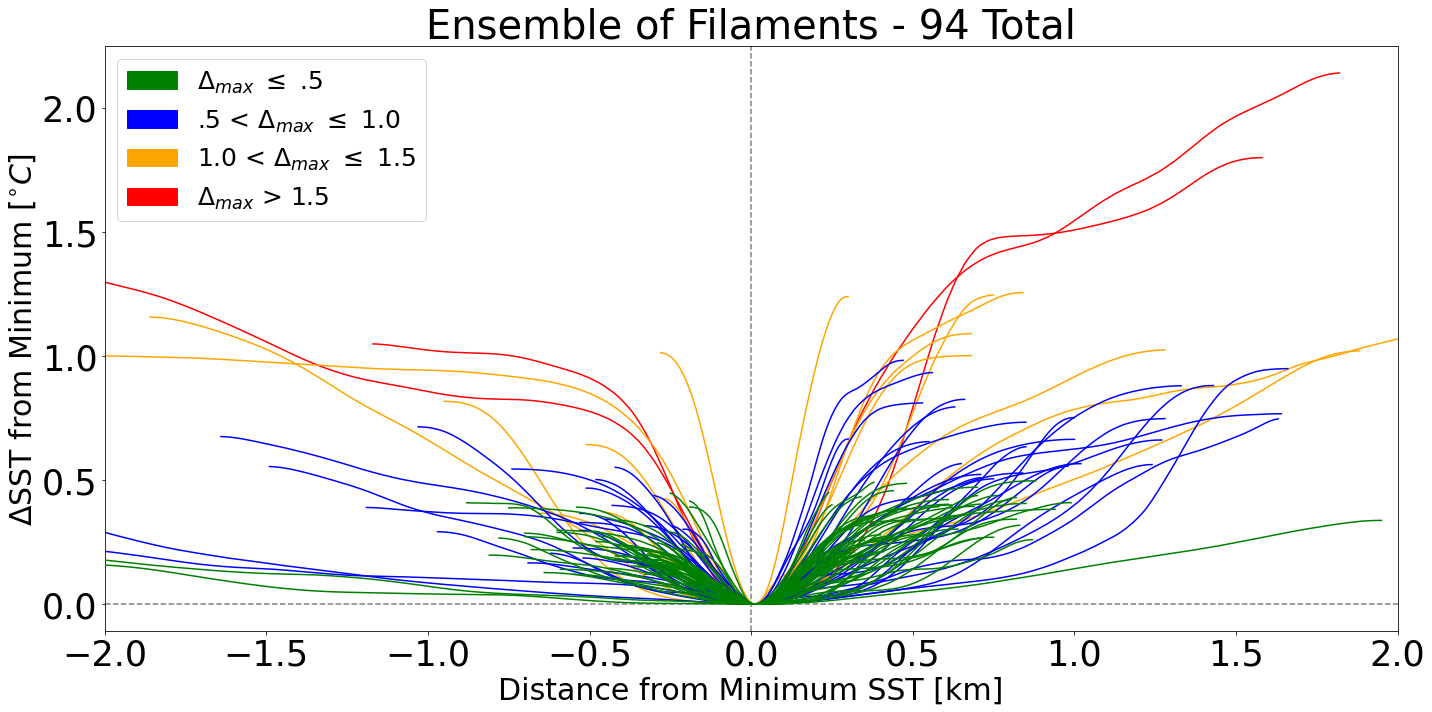

In [8]:
fil_ens_fig = plt.figure(1, (20, 10)) 

plt.axhline(y=0, linestyle = '--', color = 'k', alpha = .5)
plt.axvline(x=0, linestyle = '--', color = 'k', alpha = .5)

for i in range(len(filament_ensemble)):
    x = filament_ensemble[i+1]['Equi-Dist']
    y = filament_ensemble[i+1]['Equi-SST']
    #date = np.append(date, filament_ensemble[str(i+1)]['Date'])

    if max(y) <= .5:
        plt.plot(x, y, color = 'green', zorder=4)
    elif max(y) <= 1.0:
        plt.plot(x, y, color = 'blue', zorder=3)
    elif max(y) <= 1.5:
        plt.plot(x, y, color = 'orange', zorder=2)
    else:
        plt.plot(x, y, color = 'red', zorder=1)
        
plt.xlim(-2, 2)

plt.xlabel('Distance from Minimum SST [km]', fontsize=fs_label)
plt.ylabel('$\Delta$SST from Minimum [$^{\circ}C$]', fontsize=fs_label)

if len(cruisedate) != 0:
    plt.title(f'{cruisedate[0]} Ensemble of Filaments - {len(filament_ensemble)} Total', fontsize=fs_title)
else:
    plt.title(f'Ensemble of Filaments - {len(filament_ensemble)} Total', fontsize=fs_title)

green_patch = mpatches.Patch(color='green', label='$\Delta_{max}$ $\leq$ .5') 
blue_patch = mpatches.Patch(color='blue', label='.5 < $\Delta_{max}$ $\leq$ 1.0')
orange_patch = mpatches.Patch(color='orange', label='1.0 < $\Delta_{max}$ $\leq$ 1.5')
red_patch = mpatches.Patch(color='red', label='$\Delta_{max}$ > 1.5')
plt.legend(handles=[green_patch, blue_patch, orange_patch, red_patch], fontsize = fs_tick-10)

plt.xticks(fontsize=fs_tick), plt.yticks(fontsize=fs_tick)

plt.tight_layout()

#print(f'Cruise Dates: \n {dates}')

if saveplots == True:
    plt.savefig('all_filament_ensemble.png')

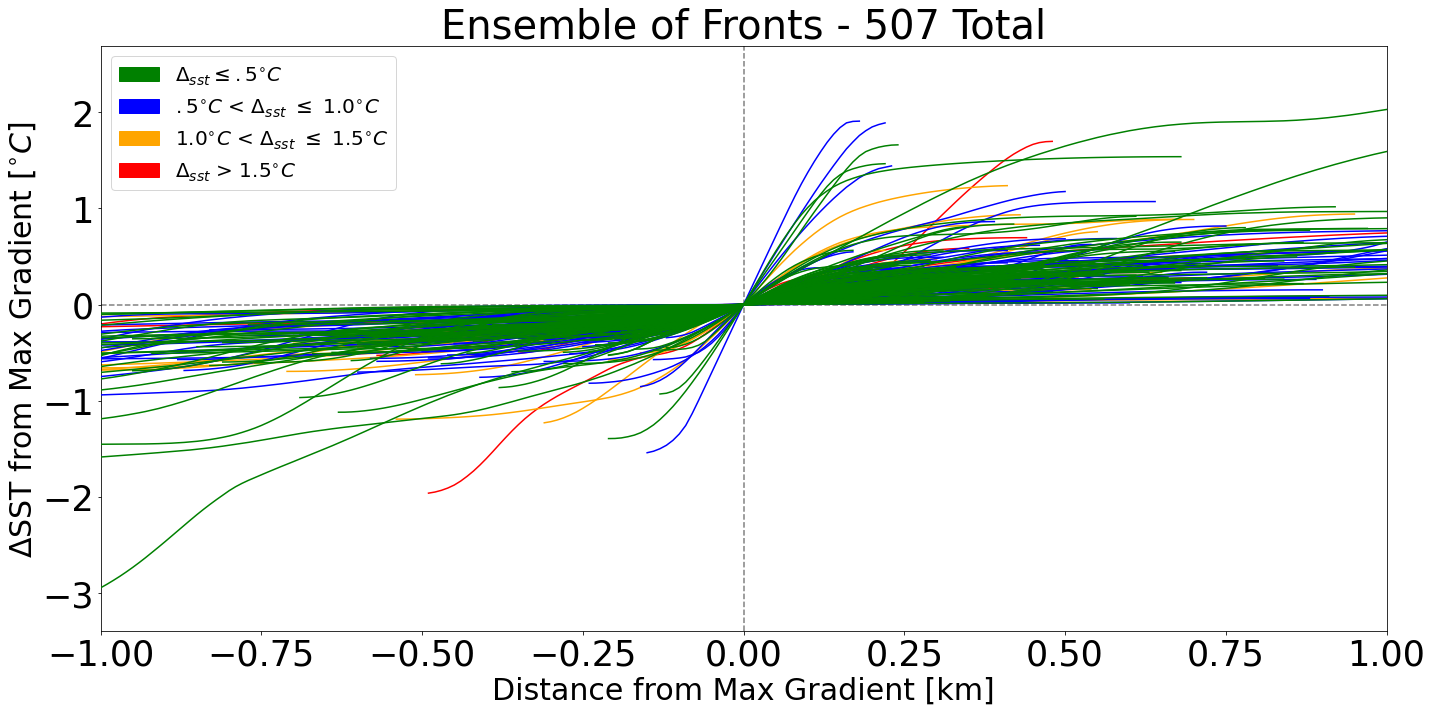

In [9]:
front_ens_fig = plt.figure(1, (20, 10)) 
legend_settings = 'sst_change'

dates = []

sum = 0
for i in range(len(front_ensemble)):
    x = front_ensemble[i+1]['Equi-Dist']
    y = front_ensemble[i+1]['Equi-SST']
    if front_width[i] > 5:
        continue
    sum = i + 1
    if legend_settings == 'width':
        if front_width[i] <= .5:
            plt.plot(x, y, color = 'green', zorder=4)
        elif front_width[i] <= 1.0:
            plt.plot(x, y, color = 'blue', zorder=3)
        elif front_width[i] <= 1.5:
            plt.plot(x, y, color = 'orange', zorder=2)
        else:
            plt.plot(x, y, color = 'red', zorder=1)
    else:
        if sst_change[i] <= .5:
            plt.plot(x, y, color = 'green', zorder=4)
        elif sst_change[i] <= 1:
            plt.plot(x, y, color = 'blue', zorder=3)
        elif sst_change[i] <= 1.5:
            plt.plot(x, y, color = 'orange', zorder=2)
        else:
            plt.plot(x, y, color = 'red', zorder=1)

dates = np.unique(date)

if legend_settings == 'width':
    green_patch = mpatches.Patch(color='green', label='$Width \leq .5km$') 
    blue_patch = mpatches.Patch(color='blue', label='.5km < $Width$ $\leq$ 1.0km')
    orange_patch = mpatches.Patch(color='orange', label='1.0km < $Width$ $\leq$ 1.5km')
    red_patch = mpatches.Patch(color='red', label='$Width$ > 1.5km')
    plt.legend(handles=[green_patch, blue_patch, orange_patch, red_patch], fontsize = 20)
else:
    green_patch = mpatches.Patch(color='green', label='$\Delta_{sst} \leq .5^{\circ}C$') 
    blue_patch = mpatches.Patch(color='blue', label='$.5^{\circ}C$ < $\Delta_{sst}$ $\leq$ 1.0$^{\circ}C$')
    orange_patch = mpatches.Patch(color='orange', label='$1.0^{\circ}C$ < $\Delta_{sst}$ $\leq$ $1.5^{\circ}C$')
    red_patch = mpatches.Patch(color='red', label='$\Delta_{sst}$ > $1.5^{\circ}C$')
    plt.legend(handles=[green_patch, blue_patch, orange_patch, red_patch], fontsize = 20)

plt.xticks(fontsize=fs_tick), plt.yticks(fontsize=fs_tick)
                
plt.xlabel('Distance from Max Gradient [km]', fontsize=fs_label)
plt.ylabel('$\Delta$SST from Max Gradient [$^{\circ}C$]', fontsize=fs_label)
if len(cruisedate) != 0:
    plt.title(f'{cruisedate[0]} Ensemble of Fronts - {sum} Total', fontsize=fs_title)
else:
    plt.title(f'Ensemble of Fronts - {sum} Total', fontsize=fs_title)


plt.axhline(y=0, linestyle = '--', color = 'k', alpha = .5)
plt.axvline(x=0, linestyle = '--', color = 'k', alpha = .5)

plt.xlim(-1, 1)

plt.tight_layout()

if saveplots == True:
    plt.savefig('all_fronts_ensemble.png')

### 3. Saving Ensembles

In [10]:
if save_ensembles:    
    import pickle
    with open('filament_ensemble.pkl', 'wb') as ztd:
        pickle.dump(filament_ensemble, ztd)
        print('filament ensemble saved successfully to file')
    with open('front_ensemble.pkl', 'wb') as ztd:
        pickle.dump(front_ensemble, ztd)
        print('front ensemble saved successfully to file')